# Embedding Metrics Comparison

This notebook demonstrates how to compare embeddings using different distance/similarity metrics.


In [1]:
import os
import json
import numpy as np
from typing import List, Dict, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine


## Setup Logging


In [2]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


## Gemini Setup


In [3]:
from google import genai
from google.genai import types

from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY_1')

MODEL_NAME = "gemini-embedding-001"
client = genai.Client(
    api_key=api_key
)

print("Setup complete!")


Setup complete!


In [4]:
def get_embeddings_gemeni(text: str, output_dimensionality: int = 10) -> list[float]:
    """Generate embeddings for the given text using Gemini"""
    result = client.models.embed_content(
        model=MODEL_NAME,
        contents=text,
        config=types.EmbedContentConfig(output_dimensionality=output_dimensionality),
    )
    return np.array(result.embeddings[0].values)


## Generate Embeddings


In [5]:
# Define test prompts
prompts = [
    "cat",
    "old cat",
    "dog",
    "kitten",
    "feline",
    "automobile"
]

# Generate and store embeddings using Gemini
embeddings_dict_gemeni = {}

for prompt in prompts:
    embeddings_gemeni = get_embeddings_gemeni(prompt)
    embeddings_dict_gemeni[prompt] = embeddings_gemeni
    logger.info(f"Generated Gemini embedding for '{prompt}' with length {len(embeddings_gemeni)}")


## Embedding Distance Metrics

Let's implement and compare different distance/similarity metrics:


In [6]:
def calculate_metrics(emb1: List[float], emb2: List[float]) -> Dict[str, float]:
    """Calculate various distance/similarity metrics between two embeddings"""

    # Convert to numpy arrays
    emb1_np = np.array(emb1, dtype=float)
    emb2_np = np.array(emb2, dtype=float)

    # Cosine similarity (higher = more similar)
    cosine_similarity = 1 - cosine(emb1_np, emb2_np)

    # Dot product (un-normalized vectors)
    dot_product = float(np.dot(emb1_np, emb2_np))

    return {
        "cosine_similarity": cosine_similarity,
        "dot_product": dot_product,
    }

In [7]:
# Compare all prompt pairs
results = []

for i, prompt1 in enumerate(prompts):
    for j, prompt2 in enumerate(prompts):
        if i < j:  # Avoid duplicates and self-comparisons
            metrics = calculate_metrics(embeddings_dict_gemeni[prompt1], embeddings_dict_gemeni[prompt2])
            results.append({
                "prompt1": prompt1,
                "prompt2": prompt2,
                **metrics
            })

# Convert to DataFrame for easier visualization
import pandas as pd
results_df = pd.DataFrame(results)
results_df


,prompt1,prompt2,cosine_similarity,dot_product
0,cat,old cat,0.906803,0.008101
1,cat,dog,0.878521,0.006125
2,cat,kitten,0.773138,0.005479
3,cat,feline,0.905886,0.006141
4,cat,automobile,0.255977,0.000831
5,old cat,dog,0.799983,0.006445
6,old cat,kitten,0.745299,0.006104
7,old cat,feline,0.872009,0.006831
8,old cat,automobile,0.194843,0.000731
9,dog,kitten,0.626326,0.004003


## Visualizing Embedding Relationships


In [8]:
# Dimensionality reduction to visualize embeddings in 2D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings_2d(method: str = "pca") -> None:
    """Plot embeddings in 2D using dimensionality reduction"""
    # Prepare data
    X = np.array([embeddings_dict_gemeni[p] for p in prompts])

    # Apply dimensionality reduction
    if method.lower() == "pca":
        reducer = PCA(n_components=2)
        title = "PCA Visualization of Gemini Embeddings"
    elif method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=2)
        title = "t-SNE Visualization of Gemini Embeddings"
    else:
        raise ValueError(f"Unknown method: {method}")

    X_2d = reducer.fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=100)

    # Add labels
    for i, prompt in enumerate(prompts):
        plt.annotate(prompt, (X_2d[i, 0], X_2d[i, 1]), fontsize=12)

    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


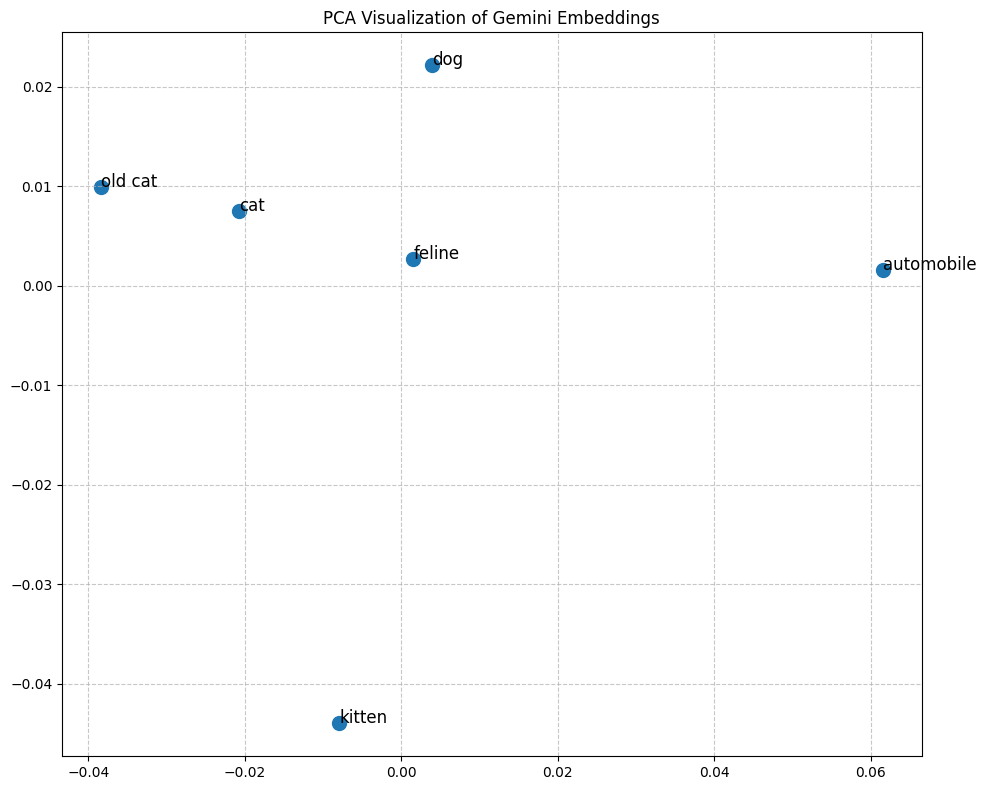

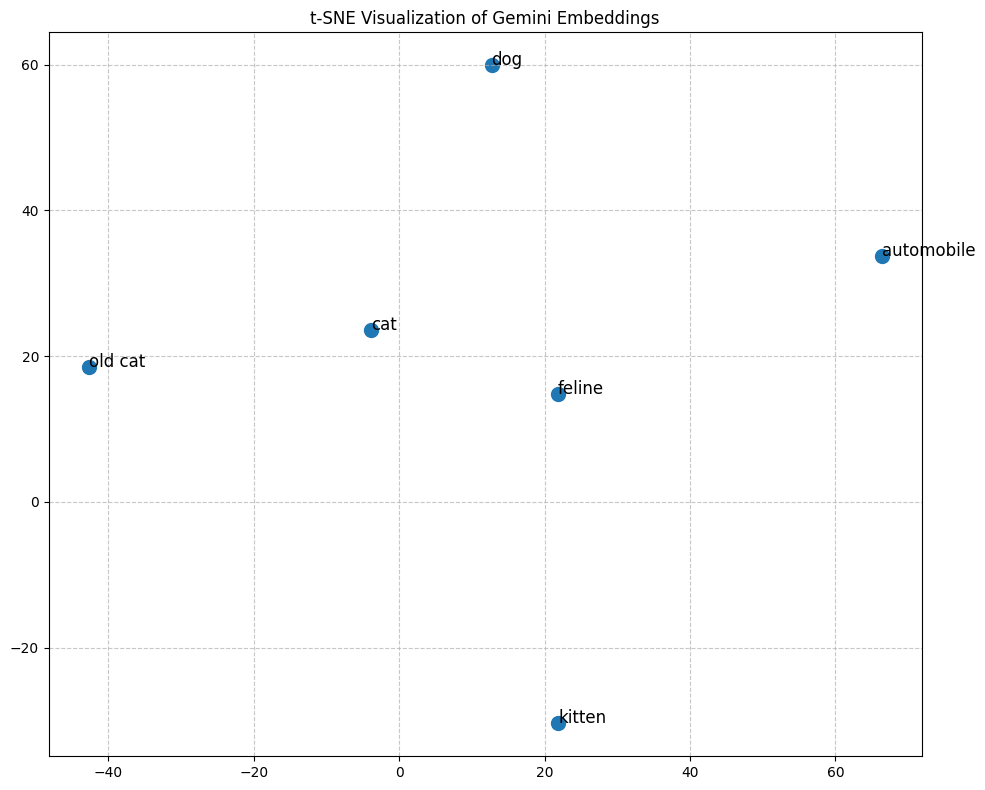

In [9]:
# Plot using PCA
plot_embeddings_2d("pca")

# Plot using t-SNE
plot_embeddings_2d("tsne")


## Analyzing Semantic Relationships

Let's find the most similar and most different prompt pairs based on cosine similarity:


In [10]:
# Sort by cosine similarity
results_df_sorted = results_df.sort_values(by="cosine_similarity", ascending=False)

# Most similar pairs
print("Most similar prompt pairs (by cosine similarity):")
print(results_df_sorted[["prompt1", "prompt2", "cosine_similarity"]].head(3))
print("\n")

# Most different pairs
print("Most different prompt pairs (by cosine similarity):")
print(results_df_sorted[["prompt1", "prompt2", "cosine_similarity"]].tail(3)[::-1])


Most similar prompt pairs (by cosine similarity):
  prompt1  prompt2  cosine_similarity
0     cat  old cat           0.906803
3     cat   feline           0.905886
1     cat      dog           0.878521


Most different prompt pairs (by cosine similarity):
    prompt1     prompt2  cosine_similarity
13   kitten  automobile           0.110247
8   old cat  automobile           0.194843
4       cat  automobile           0.255977


## Conclusion

This notebook demonstrated various metrics for comparing Gemini embeddings:

1. **Cosine Similarity**: Measures the cosine of the angle between two vectors (higher value means more similar)
2. **Dot Product**: Another similarity measure based on vector alignment

We also visualized the Gemini embeddings using dimensionality reduction techniques (PCA and t-SNE) to better understand the relationships between different prompts in the embedding space.


---

## 📚 Summary

### ✨ Key Concepts Covered

1. **Gemini Embedding Generation**: Creating vector representations using Google's Gemini API
2. **Distance Metrics**: Calculating similarity between embeddings
3. **Cosine Similarity**: Measuring angular similarity between vectors
4. **Dot Product**: Alternative similarity measure based on vector alignment
5. **Dimensionality Reduction**: Visualizing high-dimensional embeddings in 2D
6. **PCA Visualization**: Linear dimensionality reduction technique
7. **t-SNE Visualization**: Non-linear dimensionality reduction technique
8. **Semantic Analysis**: Understanding relationships between text concepts

### 💡 Key Insights

- ✅ **Cosine similarity** is most commonly used for embedding comparison
- ✅ **Gemini embeddings** provide semantic understanding of text relationships
- ✅ **Visualization techniques** help understand embedding space structure
- ✅ **Semantic clustering** groups related concepts together
- ✅ **Distance metrics** reveal semantic relationships between words

### 🎯 Real-World Applications

Embedding metrics are used in many applications:

- 🔹 **Search Engines**: Finding semantically similar documents
- 🔹 **Recommendation Systems**: Suggesting similar content
- 🔹 **Text Classification**: Grouping documents by similarity
- 🔹 **Question Answering**: Finding relevant information
- 🔹 **Chatbots**: Understanding user intent and context

### 📖 Next Steps

- 🔹 Experiment with different embedding models
- 🔹 Compare various distance metrics
- 🔹 Explore advanced visualization techniques
- 🔹 Build similarity-based applications
- 🔹 Implement embedding-based search systems

---

### 🎓 Congratulations!

You now understand how to compare Gemini embeddings using different metrics and visualize semantic relationships in high-dimensional spaces!
